# Sentiment Analysis using Movie Reviews Dataset


## Imports

In [1]:
# after installation and upgrade kernel restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import keras_nlp
import numpy as np
import shutil
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [80]:
# matplotlib settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Dataset

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [4]:
# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'unsup']

In [5]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

# configure datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [7]:
# data examples
for review, label in train_ds.take(1):
    for i in range(5):
        print(f"\nReview: {review[i]}")
        print(f"Label: {class_labels[label[i]]}: ({label[i]})")


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: neg: (0)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

## Model Setup

### Set Baseline

In [8]:
# utility function to load the model
def get_model(dropout=0.1):
    model = keras_nlp.models.BertClassifier.from_preset(
        "bert_tiny_en_uncased_sst2",
        num_classes=2,
        dropout=dropout,
    )
    return model

In [9]:
model = get_model()
model.summary(expand_nested=True)

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │   4,385,920 │ padding_mask[0][0],            │
│                               │ None, 128)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_ids (InputLayer)   │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_embedding          │ (None, None, 128)         │   3,906,816 │ -                              │
│ (ReversibleEmbedding)         │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_ids (InputLayer) │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ position_embedding       │ (None, None, 128)         │      65,536 │ -                              │
│ (PositionEmbedding)           │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_embedding        │ (None, None, 128)         │         256 │ -                              │
│ (Embedding)                   │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ add (Add)                │ (None, None, 128)         │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_layer_norm    │ (None, None, 128)         │         256 │ -                              │
│ (LayerNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_dropout       │ (None, None, 128)         │           0 │ -                              │
│ (Dropout)                     │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ padding_mask             │ (None, None)              │           0 │ -                              │
│ (InputLayer)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# save model performance to compare later
accuracy = {}

# evaluate base model with default parameters
model = get_model()
# get model's preset learning rate
print("Default learning rate:", model.optimizer.get_config()["learning_rate"])
_ = model.fit(train_ds, validation_data=val_ds, epochs=1)
# get performance
accuracy["Baseline"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"], 
                        model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Baseline model performance on the test set:", accuracy["Baseline"][1])

Default learning rate: 4.999999873689376e-05
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.3956 - sparse_categorical_accuracy: 0.8211 - val_loss: 0.3234 - val_sparse_categorical_accuracy: 0.8634
Baseline model performance on the test set: 0.8614799976348877


## Model Fine-Tuning

In [105]:
# helper function to visualize model training curves
def plot_history(history):
    """Plots training curves given training and validation 
    (accuracy, loss) keys provided in the history."""

    # get keys from the dictionary 
    hist_keys = list(history.history.keys())
    # performance plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax1.plot(history.history[hist_keys[0]])
    ax1.plot(history.history[hist_keys[2]])
    ax1.set_title('Model Loss')
    ax1.set_ylabel(hist_keys[0])
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'valid'], loc='upper left')
    ax1.grid(True)
    # loss plot
    ax2.plot(history.history[hist_keys[1]])
    ax2.plot(history.history[hist_keys[3]])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel(hist_keys[1])
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'valid'], loc='upper right')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

# def plot compare models
def plot_stats(stats):
    """Given a dictionary of (model name, model performance)
    items outputs comparative plot."""

    mode = ("Train", "Test")
    models = list(stats.keys())
    x = np.arange(len(models))  # the label locations
    y = np.round(np.array(list(accuracy.values())), 3)
    y1, y2 = y[:, 0], y[:, 1]
    width = 0.15  # the width of the bars
    plt.figure(figsize=(4, 3), layout='constrained')
    bar1 = plt.bar(x-0.1, y1, width) 
    bar2 = plt.bar(x+0.1, y2, width)
    plt.bar_label(bar1)
    plt.bar_label(bar2)
    plt.xticks(x, models)
    plt.ylim(0.8)
    plt.title("Models Test Set Performance")
    plt.legend(mode, loc='upper left', ncols=2)
    plt.grid(True)
    plt.show()

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.4154 - sparse_categorical_accuracy: 0.8103 - val_loss: 0.3350 - val_sparse_categorical_accuracy: 0.8574
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.3106 - val_sparse_categorical_accuracy: 0.8706
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2888 - sparse_categorical_accuracy: 0.8808 - val_loss: 0.2989 - val_sparse_categorical_accuracy: 0.8760
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.2907 - val_sparse_categorical_accuracy: 0.8838
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2307 - sparse_categorical_accuracy: 0.9108 - val_loss: 0.2866 - val_sparse_categorical_accuracy: 0.8852


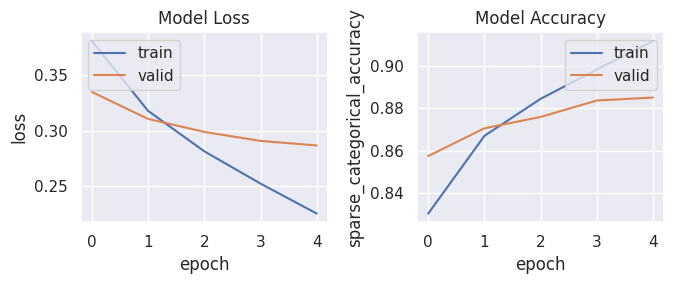

Model performance on the test set: 0.881600022315979


In [205]:
# default dropout, lower number of training epochs
model_1 = get_model(dropout=0.1)
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model_1.fit(train_ds, validation_data=val_ds, epochs=5)
plot_history(history)
accuracy["FT-1"] = (model_1.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model_1.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-1"][1])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.4159 - sparse_categorical_accuracy: 0.8103 - val_loss: 0.3359 - val_sparse_categorical_accuracy: 0.8558
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3300 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.3149 - val_sparse_categorical_accuracy: 0.8664
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2914 - sparse_categorical_accuracy: 0.8801 - val_loss: 0.2985 - val_sparse_categorical_accuracy: 0.8786
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.2895 - val_sparse_categorical_accuracy: 0.8826
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2363 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.2884 - val_sparse_categorical_accuracy: 0.8866
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9224 - val_loss: 0.2911 - val_sparse_categorical_accuracy:

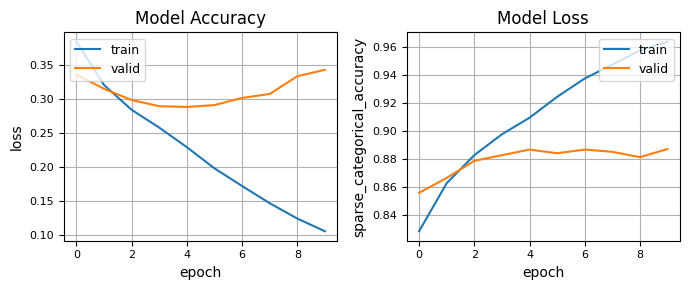

Model performance on the test set: 0.8742799758911133


In [174]:
model_2 = get_model(dropout=0.3)
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model_2.fit(train_ds, validation_data=val_ds, epochs=10)
plot_history(history)
accuracy["FT-2"] = (model_2.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model_2.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-2"][1])

Both fine-tuned models impoved baseline performance, however, model FT-2 clearly overfits the training set, whereas FT-1 has better performance, therefore it will be used in the inference process.

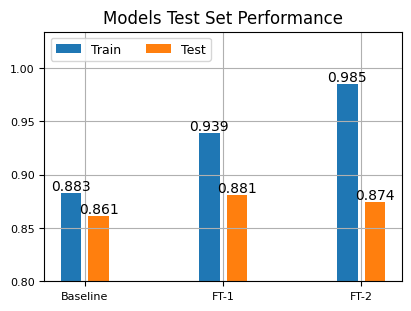

In [181]:
plot_stats(accuracy)

## Inference

Map review sentiment predictions to the sentiment range from -1 to 1: from negative (-1), neutral(0), to positive(+1).

In [25]:
# helper functions
def make_prediction(raw_review, model):
    """Args: 
    - raw_review: a single review of str type;
    - model: fine-tuned model.
    Outputs:
    - sentiment: a scalar that maps predicted review sentiments
    to fall into range [-1, 1]."""
    # convert a raw review into a tensor + batch dimension
    review = tf.expand_dims(tf.constant(raw_review), axis=0)
    # 2 neurons in the output layer, take the output of only 1 of them
    pred = model.predict(review, verbose=0)[:, 1]
    sentiment = tf.nn.tanh(pred)
    return sentiment.numpy()

def plot_bar(prediction):
    """Given a single scalar prediction plots it in a 
    colormap of a range [-1, 1]."""
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    ticks = ["negative", "neutral", "positive"]
    bounds = [-1., 0.0, 1.0]
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    ticks=bounds,
                                    orientation='horizontal')
    cb1.ax.axvline(prediction, c='green', linewidth=3)
    cb1.ax.text(prediction, 1.1, s="prediction: "+str(round(prediction[0], 2)), 
                horizontalalignment="center", fontsize=9, c="green")
    cb1.set_ticklabels(ticks)
    cb1.set_label('Sentiment Scale')

Review: This movies was wonderful, however the music was not that good.


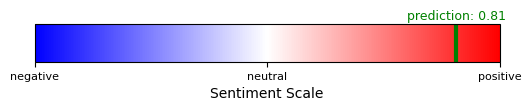

In [26]:
# test model prediction and plot result
review = "This movies was wonderful, however the music was not that good."
print("Review:", review)
plot_bar(make_prediction(review, model_1))

Review: It was okay, 5 out of 10, but i wouldn't watch it again.


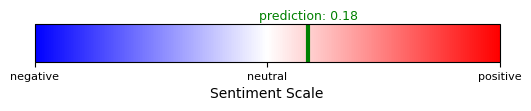

In [27]:
review = "It was okay, 5 out of 10, but i wouldn't watch it again."
print("Review:", review)
plot_bar(make_prediction(review, model_1))

Review: Movie is completely awful!


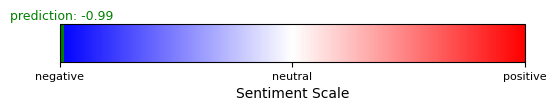

In [28]:
review = "Movie is completely awful!"
print("Review:", review)
plot_bar(make_prediction(review, model_1))

Review: tf.Tensor(b'The remarkable, sometimes infuriating, often brilliant films of John Cassavetes occupy a unique position in American cinema\xc2\x85 Low-budget, partly improvised, inspired by cin\xc3\xa9ma verit\xc3\xa9 documentary, and related to underground film, they have nevertheless frequently managed to reach a wide and profoundly appreciative audience\xc2\x85 <br /><br />After drama studies, the young Cassavetes quickly made his name as an unusually unrefined, intense actor, often appearing in films about disaffected, rebellious youth such as "Crime in the Streets" and "Edge of the City." <br /><br />Setting up an actors\' workshop, he worked to transform an improvisational experiment into his feature debut\xc2\x85 The result, "Shadows," taking three years to complete and partly financed by his performances in TV\'s Johnny Staccato, was a breakthrough in American cinema\xc2\x85 About the effect of racism on an already fraught relationship between two black men and their siste

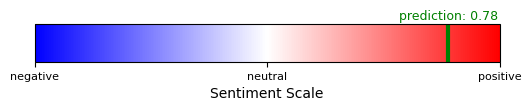

In [29]:
# test review from the test set
review_label = test_ds.unbatch().take(1)
for review, label in review_label:
    print("Review:", review)
    print("True label:", label.numpy())
    plot_bar(make_prediction(review, model_1))

## Error Analysis

In [169]:
# get true and predicted labels
y_true = tf.stack([label for _, label in test_ds.unbatch()], axis=0)
# raw model outputs
logits = model_1.predict(test_ds, verbose=0)
# class probabilities
y_proba = tf.nn.sigmoid(logits)
# predicted labels
y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)

print("Labels:", y_true)
print("Predictions:", y_pred)

Labels: tf.Tensor([1 1 0 ... 1 0 1], shape=(25000,), dtype=int32)
Predictions: tf.Tensor([1 1 0 ... 1 0 1], shape=(25000,), dtype=int32)


In [157]:
# utility functions to plot confusion matrix
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(3, 3)})
    ax.set_title('Confusion matrix of sentiment prediction for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

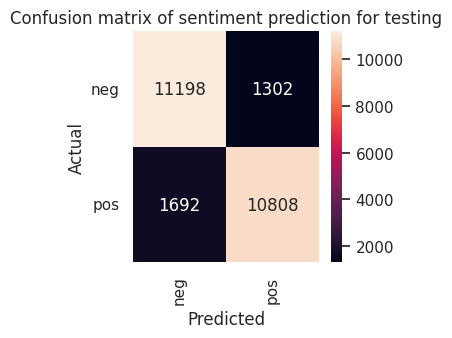

In [103]:
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")

The confusion matrix shows that the classifier produces more FN (1692) than FP (1302) at the threshold of 0.5. 

In [177]:
# get misclassified examples
missclass = [(item, y_proba[i]) for i, item in test_ds.unbatch().enumerate() if item[1] != y_pred[i]]

In [178]:
# output a few misclassified reviews
for item, pred in missclass[:5]:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b"I have always liked the Carry On films, with their double-meaning sexual innuendo dialogue and moments of slapstick comedy, but I can see why the critics give this one two stars. Basically, many British people are gathering on a coach to go on a Spanish holiday to an island called Elsbels to the Palace Hotel. What they didn't know is that it is not completely built, plus they have to share bathrooms with their neighbours, they have crap draws, and many other complications and complaints that the owner Pepe (Peter Butterworth, putting on quite an amusing accent, e.g. peace sounding like the bad P word). Starring Sid James as Vic Flange, Kenneth Williams as Stuart Farquhar, Charles Hawtrey as Eustace Tuttle, Joan Sims as Cora Flange, Barbara Windsor as Sadie Tomkins, Kenneth Connor as Stanley Blunt, an apparently crap (I personally can't remember who he is) Jimmy Logan as Bert Conway, June Whitfield as Evelyn Blunt, Hattie Jacques as Floella (a ridiculous hag charact